In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from py_utils.FINDER_test_utils import *
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

# Plot synthetic test set performance of specific models

## Specify test sets

In [4]:
test_set_0 = 'tsp_min-n=15_max-n=20_num-graph=1000_type=random'
test_set_1 = 'tsp_min-n=40_max-n=50_num-graph=1000_type=random'
test_set_2 = 'tsp_min-n=50_max-n=100_num-graph=1000_type=random'
test_set_names = [test_set_0, test_set_1, test_set_2]

In [3]:
test_set_0 = 'synthetic_n_20_1000'
test_set_1 = 'synthetic_n_50_1000'
test_set_names = [test_set_0, test_set_1]

## Specifiy model paths and model names (to load results files)

In [4]:
# model_names = [
#     'concat_decoder_2021-10-16_23:59:37_len_100308',
#     'dropout_2021-10-17_07:11:04_len_100242',
#     'probability_masking_2021-10-17_14:20:41_len_100175',
#     'sparsified_graph_2021-10-17_19:32:44_len_100337',
#     'standard_2021-10-18_02:36:38_len_100324'
# ]
model_names = [
    'AGNN_no_help_only_start_end_+_edge_prob_+_unfixed_start_2021-09-08_17:31:23_len_100143',
    'standard_2021-10-18_02:36:38_len_100324'
]

In [5]:
# label models
labels = [
    'Sum state representation', 
    'Dropout 0.1', 
    'Probability masking', 
    'Sparsified graph', 
    'Standard'
]
labels = [
    'Old model', 
    'Standard'
]
competitor_labels = [
    'Kool et al. AM',
    'POMO, x8 augmentation',
    'Fu et al. state-of-the-art'
]

In [6]:
def extract_search_strategies(model_name, test_sets, length):
    # extract all search strategies
    search_strategies = None
    for test_set in test_sets:
        try:
            files = os.listdir(f'./results/{model_name}/test_sets/{test_set}/')
        except:
            continue
        strats = ['_'.join(f.split('.')[0].split('_')[1::])[length::] for f in files if 'solutions' in f]
        if search_strategies is not None:
            search_strategies.extend(strats)
        else:
            search_strategies = strats
    return search_strategies

In [7]:
result_dict = dict()
for k, model_name in tqdm(enumerate(model_names)):
    short_name = '_'.join(model_name.split('_')[0:-4])
    print(short_name)
    length = len(short_name) + 1
    search_dict = dict()
    search_strategies = extract_search_strategies(model_name, test_set_names, length)
    for search_strategy in search_strategies:
        test_dict = dict()
        for test_set in test_set_names:
            try:
                means, stds = get_test_approx_ratios_for_model([test_set], model_name, search_strategy=search_strategy)
            except:
                means = np.nan
                stds = np.nan
            test_dict[test_set] = [100 * means[0], 100 * stds[0]]
        search_dict[search_strategy] = test_dict
    result_dict[short_name] = search_dict

0it [00:00, ?it/s]

AGNN_no_help_only_start_end_+_edge_prob_+_unfixed_start


1it [00:00,  2.02it/s]

standard


2it [00:02,  1.04s/it]


In [8]:
result_dict

{'AGNN_no_help_only_start_end_+_edge_prob_+_unfixed_start': {'beam_search+_128': {'synthetic_n_20_1000': [100.0047193723866,
    0.05775654892309135],
   'synthetic_n_50_1000': [nan, nan]},
  'greedy': {'synthetic_n_20_1000': [nan, nan],
   'synthetic_n_50_1000': [122.30999456813943, 7.315767229936554]}},
 'standard': {'greedy': {'synthetic_n_20_1000': [100.8371726664478,
    1.94398277932189],
   'synthetic_n_50_1000': [111.23045324844665, 5.696978163357481]},
  'beam_search+_512': {'synthetic_n_20_1000': [100.01153779990042,
    0.1202403247146688],
   'synthetic_n_50_1000': [nan, nan]},
  'sampling_2': {'synthetic_n_20_1000': [100.39144948762595,
    1.3245326995906257],
   'synthetic_n_50_1000': [nan, nan]},
  'sampling_64': {'synthetic_n_20_1000': [100.03165998881143,
    0.21167398367302692],
   'synthetic_n_50_1000': [nan, nan]}}}

In [9]:
# s2v_dqn_mean_approx_ratios = [1.0147]#, 1.0511, 1.0702]
kool_am_approx_ratios = [1.0008, 1.0052, 1.0226]
pomo_approx_ratios = [1.00004, 1.0003, 1.0014]
sota_approx_ratios = [1.0000004, 1.000145, 1.00037]
# make external data acessible
result_dict['kool'] = {'none': {test_set: [kool_am_approx_ratios[k] * 100, 0] for k, test_set in enumerate(test_set_names)}}
result_dict['pomo'] = {'none': {test_set: [pomo_approx_ratios[k] * 100, 0] for k, test_set in enumerate(test_set_names)}}
result_dict['sota'] = {'none': {test_set: [sota_approx_ratios[k] * 100, 0] for k, test_set in enumerate(test_set_names)}}

In [16]:
def polish_search_strat(raw_strat):
    if 'greedy' in raw_strat:
        final_strat = ' greedy'
    elif 'beam_search+' in raw_strat:
        width = raw_strat.split('_')[-1]
        final_strat = f' BS+ (width={width})'
    elif 'beam_search' in raw_strat:
        width = raw_strat.split('_')[-1]
        final_strat = f' BS (width={width})'
    elif 'sampling' in raw_strat:
        sample_steps = raw_strat.split('_')[-1]
        final_strat = f' Sampling (steps={sample_steps})'
    return final_strat

In [17]:
# prepare data for plot
full_labels = []
short_names = []
mean_errors = []
stds_errors = []
for k, key in enumerate(result_dict):
    for strat in result_dict[key]:
        if strat == 'none':
            full_labels.append(competitor_labels[k - len(labels)])
            short_names.append(competitor_labels[k - len(labels)])
        else:    
            strat_string = polish_search_strat(strat)
            full_labels.append(labels[k] + strat_string)
            short_names.append(labels[k])
        # extract error data
        local_errors = [result_dict[key][strat][test_set][0] - 100 for test_set in result_dict[key][strat]]
        local_stds = [result_dict[key][strat][test_set][1] for test_set in result_dict[key][strat]]
        mean_errors.append(local_errors)
        stds_errors.append(local_stds)
# remove duplicates
# full_labels = [i for n, i in enumerate(full_labels) if i not in full_labels[:n]]

In [18]:
def plot_test_performance(mean_errors, model_names, save_path='plots/testset_performance_new.png', width=0.05):
    mpl.style.use('seaborn-paper')
    fig, axs = plt.subplots(1, 1, figsize=(10,3.5), sharex=False, sharey=False)

    num_test_sets = len(mean_errors[0])
    num_models = len(mean_errors)
    # number of testsets
    x = np.arange(0,num_test_sets)
    cmap = mpl.cm.get_cmap('Paired')

    rgba = cmap(np.arange(0,1,1/num_models))
    for k, model_name in enumerate(model_names):
        offset = width * num_models / 2 - width / 2
        pos = x + k * width - offset
        # if model_name[]
        axs.bar(pos, mean_errors[k], label=f'{model_name} ({np.round(mean_errors[k], 5)})', width=width, color=rgba[k])
    axs.legend(bbox_to_anchor=(1,1), loc="upper left")
    axs.grid(True, axis='y')
    axs.set_ylabel('Relative error to optimal [%]')
    axs.set_title('Test set performance')
    axs.set_xticks(x)
    axs.set_ylim([0,5])
    test_set_ticks = ['20', '50', '100']
    axs.set_xticklabels(test_set_ticks[0:num_test_sets])
    axs.set_xlabel('Number of nodes per TSP sample')
    plt.tight_layout()
    plt.savefig(save_path, dpi=400)

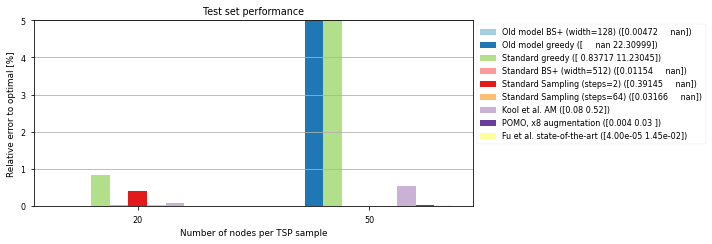

In [19]:
plot_test_performance(mean_errors, full_labels, save_path='plots/testset_performance_new.png', width=0.08)

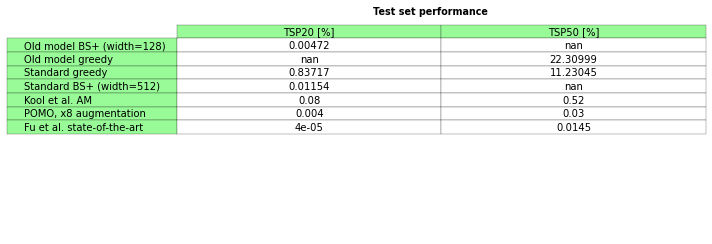

In [191]:
# plot data as table
rowLabels = full_labels
colLabels = ['TSP20 [%]', 'TSP50 [%]']
cellText = [ [str(np.round(error,5)) for error in errors] for errors in mean_errors]
mpl.style.use('seaborn-paper')
fig, ax = plt.subplots(1, 1, figsize=(10,3.5), sharex=False, sharey=False)
ax.set_axis_off() 
table = ax.table( 
    cellText = cellText,  
    rowLabels = rowLabels,  
    colLabels = colLabels, 
    rowColours =["palegreen"] * len(rowLabels),  
    colColours =["palegreen"] * len(colLabels), 
    cellLoc ='center',  
    loc ='upper left')         
   
ax.set_title('Test set performance', 
             fontweight ="bold") 
plt.tight_layout()
plt.savefig('plots/Test set performance data.png', dpi=400)    
plt.show()


In [54]:
search_strategy = 'greedy'

mean_approx_ratios = []
std_approx_ratios = []
for model_name in model_names:
    means, stds = get_test_approx_ratios_for_model(test_set_names, model_name, search_strategy=search_strategy)
    mean_approx_ratios.append(means)
    std_approx_ratios.append(stds)



s2v_dqn_mean_approx_ratios = [1.0147, 1.0511, 1.0702]
sota_approx_ratios = [1.0000, 1.002, 1.014]

mean_approx_ratios.append(s2v_dqn_mean_approx_ratios)
mean_approx_ratios.append(sota_approx_ratios)
mean_errors = [list(np.array(entry) - 1) for entry in mean_approx_ratios]


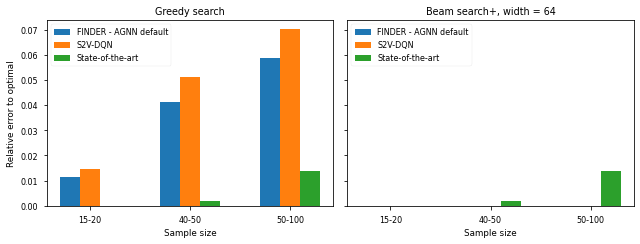

In [98]:
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 2, figsize=(9,3.5), sharex=False, sharey=True)

width = 0.2
num_test_sets = len(mean_approx_ratios[0])
num_models = len(mean_approx_ratios)
# number of testsets
x = np.arange(0,num_test_sets)
for k, model_name in enumerate(model_names_short):
    offset = width * num_models / 2 - width / 2
    pos = x + k * width - offset
    axs[0].bar(pos, mean_errors[k], label=model_name, width=width)
# axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Relative error to optimal')
axs[0].set_title('Greedy search')


for k, model_name in enumerate(model_names_short):
    offset = width * num_models / 2 - width / 2
    pos = x + k * width - offset
    axs[1].bar(pos, mean_errors_beam[k], label=model_name, width=width)
axs[1].legend(loc='upper left')
axs[1].set_title('Beam search+, width = 64')


for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(['15-20', '40-50', '50-100'])
    ax.set_xlabel('Sample size')
    # ax.set_ylim([1, 1.075])
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance.png', dpi=400)

In [6]:
model_path_0 =  'best_models/tsp_2d/nrange_15_20_len_1011362/'
model_file_0, model_base_path, tour_length = get_model_file(model_path_0)
model_name_0 = model_file_0.split('.')[0]

model_path_2 =  'best_models/tsp_2d/nrange_15_20_len_1012015/' # 'best_models/tsp_2d/nrange_15_20_len_1011194/'
model_file_2, model_base_path, tour_length = get_model_file(model_path_2)
model_name_2 = model_file_2.split('.')[0]

Best model file: nrange_15_20_iter_3900_len_1011362.ckpt
Best model file: nrange_15_20_iter_1500_len_1012015.ckpt


In [7]:
model_names = [model_name_0, model_name_2]
mean_approx_ratio_list = []
for model_name in model_names:
    model_means = mean_approx_ratios_for_model(folder_names, model_name)
    mean_approx_ratio_list.append(model_means)

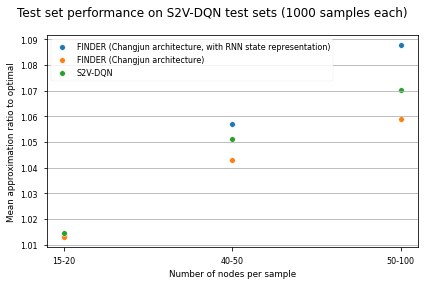

In [8]:
# architecture_0 = 'FINDER (Changjun architecture, selection through large validation set)'
architecture_0 = 'FINDER (Changjun architecture, with RNN state representation)'
architecture_1 = 'FINDER (Changjun architecture)'
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 1, figsize=(6,4), sharex=True, sharey=True)
x = np.arange(0,len(mean_approx_ratio_list[0]))
sns.scatterplot(x=x,y=mean_approx_ratio_list[0], ax=axs, label=architecture_0)
sns.scatterplot(x=x,y=mean_approx_ratio_list[1], ax=axs, label=architecture_1)
sns.scatterplot(x=x,y=s2v_dqn_mean_approx_ratios, ax=axs, label='S2V-DQN')
axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs.legend(loc='upper left')
axs.set_xticks(x)
axs.set_xticklabels(['15-20', '40-50', '50-100'])
axs.set_ylabel('Mean approximation ratio to optimal')
axs.set_xlabel('Number of nodes per sample')
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance_changjun.png', dpi=400)

In [8]:
model_path =  'best_models/tsp_2d/nrange_15_20_len_1012015/' # 'best_models/tsp_2d/nrange_15_20_len_1011194/'
model_file, model_base_path, tour_length = get_model_file(model_path)
model_name = model_file.split('.')[0]
model_names = [model_name]
mean_approx_ratio_list = []
for model_name in model_names:
    model_means = mean_approx_ratios_for_model(folder_names, model_name)
    mean_approx_ratio_list.append(model_means)

Best model file: nrange_15_20_iter_1500_len_1012015.ckpt


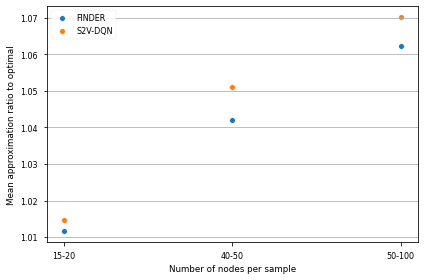

In [9]:
# architecture_0 = 'FINDER (Changjun architecture, selection through large validation set)'
architecture_0 = 'FINDER'
mpl.style.use('seaborn-paper')

fig, axs = plt.subplots(1, 1, figsize=(6,4), sharex=True, sharey=True)
x = np.arange(0,len(mean_approx_ratio_list[0]))
sns.scatterplot(x=x,y=mean_approx_ratio_list[0], ax=axs, label=architecture_0)
sns.scatterplot(x=x,y=s2v_dqn_mean_approx_ratios, ax=axs, label='S2V-DQN')
axs.grid(True, axis='y')
# axs.axhline(y = 1.015, color = 'black', linestyle = '--', label='S2V-DQN (1.0147)')
axs.legend(loc='upper left')
axs.set_xticks(x)
axs.set_xticklabels(['15-20', '40-50', '50-100'])
axs.set_ylabel('Mean approximation ratio to optimal')
axs.set_xlabel('Number of nodes per sample')
# plt.suptitle('Test set performance on S2V-DQN test sets (1000 samples each)')
plt.tight_layout()

plt.savefig(f'plots/testset_performance_FINDER_current.png', dpi=400)